<a href="https://colab.research.google.com/github/Teodosiodg2002/Analisis-Datos-Medicos-Urgencias/blob/main/AnalisisDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏥 Práctica: Análisis Avanzado de Datos Médicos de Urgencias

## 📋 Descripción del Proyecto

Este proyecto realiza un análisis exhaustivo de datos clínicos de urgencias hospitalarias utilizando técnicas de ciencia de datos. Trabajaremos con múltiples datasets que contienen información de pacientes, diagnósticos, signos vitales y medicación, con el objetivo de identificar patrones mediante clustering y descubrir asociaciones relevantes entre variables clínicas.



## 🎯 Objetivos de la Práctica

### Objetivos Generales
1. **Integración de datos**: Fusionar múltiples tablas de un dataset médico real para crear una vista unificada
2. **Preprocesamiento robusto**: Aplicar técnicas de limpieza, detección de outliers e imputación de valores faltantes
3. **Ingeniería de características**: Crear variables derivadas y transformar datos para análisis avanzado
4. **Análisis de clustering**: Identificar grupos de pacientes con características similares usando algoritmos no supervisados
5. **Minería de reglas de asociación**: Descubrir patrones y relaciones entre síntomas, diagnósticos y tratamientos


### Requisitos
- Python 3.8+
- pandas, matplotlib, icd10 (instalable vía pip)
- Archivos .csv.gz

### Archivos de Datos
Los siguientes archivos deben estar disponibles en tu Google Drive:
- `edstays.csv.gz`
- `diagnosis.csv.gz`
- `triage.csv.gz`
- `vitalsign.csv.gz`
- `pyxis.csv`
- `medrecon.csv`

**Ubicación recomendada**: `/content/drive/MyDrive/datos/`


In [18]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive montado correctamente")
print("📁 Ruta de datos: /content/drive/MyDrive/datos/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive montado correctamente
📁 Ruta de datos: /content/drive/MyDrive/datos/


## 1️⃣ Carga de Datasets

En esta sección importaremos los 6 datasets necesarios para el análisis. Todos los archivos deben estar ubicados en la carpeta `/content/drive/MyDrive/datos/` de tu Google Drive.

### 📂 Archivos Requeridos
- `edstays.csv.gz` - Estancias en urgencias (tabla principal)
- `diagnosis.csv.gz` - Diagnósticos ICD por estancia
- `triage.csv.gz` - Signos vitales del triage inicial
- `vitalsign.csv.gz` - Signos vitales durante la estancia
- `pyxis.csv` - Medicamentos dispensados (máquinas automáticas)
- `medrecon.csv` - Reconciliación de medicación del paciente

### 🔧 Configuración de Librerías

Primero importamos las librerías necesarias y configuramos el entorno para evitar warnings innecesarios que puedan ensuciar la salida.

In [19]:
# ==========================================
# IMPORTACIÓN DE LIBRERÍAS BASE
# ==========================================
from pathlib import Path
import pandas as pd
import numpy as np
import warnings

# Suprimir warnings de deprecación para mantener la salida limpia
# Esto es especialmente útil en Google Colab donde pueden aparecer múltiples warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Configuración adicional de pandas para mejor visualización
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', 100)      # Mostrar hasta 100 filas
pd.set_option('display.width', None)        # Ancho automático

### 📥 Carga de los Datasets


In [20]:
# ==========================================
# CARGA DE DATASETS
# ==========================================
# Definimos la ruta donde se encuentran los archivos
DATA_DIR = Path('/content/drive/MyDrive/datos/')

# Cargamos cada dataset
try:
    df_edstays = pd.read_csv(DATA_DIR / 'edstays.csv.gz')
    print("edstays.csv.gz cargado")

    df_diagnosis = pd.read_csv(DATA_DIR / 'diagnosis.csv.gz')
    print("diagnosis.csv.gz cargado")

    df_triage = pd.read_csv(DATA_DIR / 'triage.csv.gz')
    print("triage.csv.gz cargado")

    df_vitalsign = pd.read_csv(DATA_DIR / 'vitalsign.csv.gz')
    print("vitalsign.csv.gz cargado")

    df_medrecon = pd.read_csv(DATA_DIR / 'medrecon.csv')
    print("medrecon.csv cargado")

    df_pyxis = pd.read_csv(DATA_DIR / 'pyxis.csv')
    print("pyxis.csv cargado")

except FileNotFoundError as e:
    print(f"Error: Archivo no encontrado - {e}")
    print("Verifica que todos los archivos estén en la carpeta correcta.")
except Exception as e:
    print(f"Error inesperado al cargar archivos: {e}")


edstays.csv.gz cargado
diagnosis.csv.gz cargado
triage.csv.gz cargado
vitalsign.csv.gz cargado
medrecon.csv cargado
pyxis.csv cargado


### 📊 Verificación de Dimensiones


In [21]:
# ==========================================
# VERIFICACIÓN DE DIMENSIONES
# ==========================================

datasets = {
    'edstays': df_edstays,
    'diagnosis': df_diagnosis,
    'triage': df_triage,
    'vitalsign': df_vitalsign,
    'medrecon': df_medrecon,
    'pyxis': df_pyxis
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")

edstays: (222, 9)
diagnosis: (545, 6)
triage: (222, 11)
vitalsign: (1038, 11)
medrecon: (2764, 9)
pyxis: (1082, 7)


### FUSION DE LOS DATASETS


In [22]:
'''
Paso 1: Normalización de Tipos de Datos

Antes de trabajar con los datos, debemos asegurarnos de que las columnas numéricas estén en el formato correcto.

Problema común: En datos clínicos reales, los valores numéricos a veces se guardan como texto (`'N/A'`, `'unknown'`, `'--'`), lo que impide realizar cálculos estadísticos.

Solución: Usar `pd.to_numeric()` con `errors='coerce'` para convertir valores inválidos a `NaN`.

'''

# Columnas a convertir en cada tabla
cols_to_numeric_triage = ['temperature', 'heartrate', 'resprate', 'o2sat',
                          'sbp', 'dbp', 'pain', 'acuity']
cols_to_numeric_vitals = ['temperature', 'heartrate', 'resprate', 'o2sat',
                          'sbp', 'dbp', 'pain']


# Conversión a numérico con coerción
# 'coerce' convierte valores no numéricos (ej. 'N/A', 'unk') a NaN
df_triage[cols_to_numeric_triage] = df_triage[cols_to_numeric_triage].apply(
    lambda s: pd.to_numeric(s, errors='coerce')
)

df_vitalsign[cols_to_numeric_vitals] = df_vitalsign[cols_to_numeric_vitals].apply(
    lambda s: pd.to_numeric(s, errors='coerce')
)


# Convertir timestamps a tipo datetime
if 'charttime' in df_vitalsign.columns:
    df_vitalsign['charttime'] = pd.to_datetime(df_vitalsign['charttime'], errors='coerce')


'''
Paso 2: Concatenación de Mediciones (Triage + Vitalsign)

Decisión de diseño: Tanto `triage` como `vitalsign` contienen signos vitales del paciente. La diferencia es:
- Triage: Medición inicial al ingresar a urgencias
- Vitalsign: Mediciones durante la estancia

Como ambas tablas tienen columnas similares (temperatura, frecuencia cardíaca, etc.), las concatenamos para luego calcular valores agregados por `stay_id`.
'''

# Seleccionar columnas relevantes de cada tabla
triage_subset = ['stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat',
                 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

vitals_subset = ['stay_id', 'charttime', 'rhythm', 'temperature', 'heartrate',
                 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']

# Crear subconjuntos con las columnas seleccionadas
triage_subset_df = df_triage[triage_subset]
vitals_subset_df = df_vitalsign[vitals_subset]

# Apilar las dos tablas verticalmente
# ignore_index=True genera un índice nuevo continuo
all_vitals_data = pd.concat([triage_subset_df, vitals_subset_df],
                            ignore_index=True, sort=False)


'''
Paso 3: Agregación de Mediciones por Stay_ID

Objetivo: Reducir múltiples mediciones de cada `stay_id` a una sola fila con valores representativos.

Estrategias de agregación:
- Variables fisiológicas continuas → Media (valor típico)
- Valores máximos/mínimos → Para detectar casos extremos (ej. fiebre máxima, hipoxia mínima)
- Variables categóricas → Moda (valor más frecuente) o primer valor registrado

Función Auxiliar: Calcular Moda

'''

def get_mode(x):
    """
    Calcula la moda (valor más frecuente) de una serie.

    Args:
        x: Serie de pandas con valores (puede contener NaN)

    Returns:
        El valor más frecuente, o NaN si la serie está vacía
    """
    m = x.dropna().mode()
    if not m.empty:
        return m.iloc[0]
    return np.nan

# ==========================================
# AGREGACIÓN: SIGNOS VITALES POR ESTANCIA
# ==========================================

vitals_summary = (
    all_vitals_data
    .groupby('stay_id', dropna=False)
    .agg(
        # Temperatura: guardamos máxima y mínima (detección de fiebre/hipotermia)
        temperature_max=('temperature', 'max'),
        temperature_min=('temperature', 'min'),

        # Media de variables fisiológicas
        heartrate=('heartrate', 'mean'),
        resprate=('resprate', 'mean'),

        # O2sat: mínimo (detectar hipoxia)
        o2sat=('o2sat', 'min'),

        # Presión arterial: máximos (detectar hipertensión)
        sbp=('sbp', 'max'),
        dbp=('dbp', 'max'),

        # Dolor: máximo reportado
        pain=('pain', 'max'),

        # Variables categóricas: moda o primer valor
        acuity=('acuity', get_mode),
        chiefcomplaint=('chiefcomplaint', 'first'),
        charttime=('charttime', get_mode),
        rhythm=('rhythm', get_mode)
    )
    .reset_index()
)


# ==========================================
# AGREGACIÓN: DIAGNÓSTICOS POR ESTANCIA
# ==========================================

diag_summary = (
    df_diagnosis
    .groupby('stay_id', dropna=False)
    .agg(
        # Códigos ICD únicos concatenados (separados por coma)
        all_icd_codes=('icd_code', lambda x: ', '.join(sorted(set(x.dropna().astype(str))))),

        # Títulos de diagnósticos únicos (separados por pipe)
        all_icd_titles=('icd_title', lambda x: ' | '.join(sorted(set(x.dropna().astype(str))))),

        # Número total de diagnósticos
        num_diagnoses=('seq_num', 'count'),

        # Versión ICD (normalmente todos son iguales por estancia)
        icd_version=('icd_version', 'first')
    )
    .reset_index()
)


# ==========================================
# AGREGACIÓN: MEDICAMENTOS POR ESTANCIA
# ==========================================

# Seleccionar columnas relevantes de cada tabla de medicación
pyxis_subset = df_pyxis[['stay_id', 'name', 'gsn']]
medrecon_subset = df_medrecon[['stay_id', 'name', 'etcdescription', 'gsn', 'ndc']]

# Concatenar ambas fuentes de medicación
all_meds_data = pd.concat([pyxis_subset, medrecon_subset],
                         ignore_index=True, sort=False)

# Agrupar por estancia
meds_agrupacion = (
    all_meds_data
    .groupby('stay_id', dropna=False)
    .agg(
        # Nombres únicos de medicamentos (como lista)
        all_med_names=('name', lambda x: list(x.dropna().unique())),

        # Clases terapéuticas únicas (como lista)
        all_med_classes=('etcdescription', lambda x: list(x.dropna().unique())),

        # Códigos GSN únicos (Generic Sequence Number)
        all_gsn_codes=('gsn', lambda x: list(x.dropna().unique())),

        # Códigos NDC únicos (National Drug Code)
        all_ndc_codes=('ndc', lambda x: list(x.dropna().unique())),

        # Conteo total de registros de medicación
        total_meds_count=('name', 'count')
    )
    .reset_index()
)

'''
Paso 4: Fusión Final de Todas las Tablas

Ahora unimos todas las tablas agregadas con la tabla principal `edstays` usando **LEFT JOIN** para preservar todas las estancias.

Pasos para la fusión:
- `edstays` es la tabla base (contiene todas las estancias)
- LEFT JOIN asegura que no perdemos estancias aunque no tengan diagnósticos/vitales/medicamentos
- Las estancias sin match tendrán valores `NaN` en las columnas correspondientes
'''

# Partir de la tabla principal de estancias
df_final = df_edstays.copy()

# Unir diagnósticos (LEFT JOIN mantiene todas las estancias)
df_final = df_final.merge(diag_summary, on='stay_id', how='left')

# Unir signos vitales agregados
df_final = df_final.merge(vitals_summary, on='stay_id', how='left')

# Unir medicamentos agregados
df_final = df_final.merge(meds_agrupacion, on='stay_id', how='left')

# Eliminar IDs redundantes que no necesitamos para el análisis
df_final = df_final.drop(columns=['subject_id', 'hadm_id'], errors='ignore')

print("="*70)
print("FUSIÓN COMPLETADA: df_final")
print("="*70)
print(f"Dimensiones finales: {df_final.shape[0]:,} filas × {df_final.shape[1]} columnas")
print(f"\nColumnas incluidas:")
print(f"  - De edstays: {len(df_edstays.columns)} columnas base")
print(f"  - De diagnósticos: {len(diag_summary.columns)-1} columnas")
print(f"  - De signos vitales: {len(vitals_summary.columns)-1} columnas")
print(f"  - De medicamentos: {len(meds_agrupacion.columns)-1} columnas")
print("="*70)

# ==========================================
# VERIFICACION DE df_final
# ==========================================

print("\nPrimeras filas de df_final:")
display(df_final.head(3))

print("\nInformación de la estructura:")
df_final.info()


FUSIÓN COMPLETADA: df_final
Dimensiones finales: 222 filas × 28 columnas

Columnas incluidas:
  - De edstays: 9 columnas base
  - De diagnósticos: 4 columnas
  - De signos vitales: 12 columnas
  - De medicamentos: 5 columnas

Primeras filas de df_final:


,stay_id,intime,outtime,gender,race,arrival_transport,disposition,all_icd_codes,all_icd_titles,num_diagnoses,icd_version,temperature_max,temperature_min,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,charttime,rhythm,all_med_names,all_med_classes,all_gsn_codes,all_ndc_codes,total_meds_count
0,37887480,2125-03-19 12:36:00,2125-03-19 16:59:47,F,WHITE - OTHER EUROPEAN,WALK IN,ADMITTED,"0389, 78552, 99592, E9479",ADV EFF MEDICINAL NOS | SEPTIC SHOCK | SEPTICE...,4.0,9.0,99.8,98.9,113.714286,21.666667,97.0,132.0,96.0,10.0,1.0,FEVER,2125-03-19 13:07:00,Sinus Tachycardia,"[CefePIME, Lorazepam, Vancomycin, Ondansetron,...","[Contraceptive Oral - Monophasic, Laxative - S...","[78733.0, 3753.0, 3755.0, 9329.0, 43952.0, 158...","[16714040501.0, 11822511040.0, 13107010701.0, ...",14.0
1,34176810,2154-02-05 17:09:00,2154-02-05 22:54:00,F,WHITE,AMBULANCE,ADMITTED,R55,Syncope and collapse,1.0,10.0,97.7,97.7,67.500000,18.666667,96.0,175.0,66.0,3.0,2.0,"Syncope, Transfer",2154-02-05 17:11:00,NaN,"[enalapril maleate, zolpidem, aspirin, Vitamin...","[ACE Inhibitors, Sedative-Hypnotic - GABA-Rece...","[386.0, 19188.0, 22159.0, 2173.0, 5139.0, 1636...","[15338023330.0, 10544034828.0, 45802064287.0, ...",7.0
2,32103106,2154-08-03 15:31:00,2154-08-03 22:29:00,F,WHITE,AMBULANCE,HOME,H9312,"Tinnitus, left ear",1.0,10.0,98.2,96.2,73.250000,17.500000,96.0,149.0,83.0,0.0,2.0,"N/V, Tinnitus",2154-08-03 15:34:00,NaN,"[Potassium Chloride 10mEq TAB, Vasotec, Bayer ...","[ACE Inhibitors, Salicylate Analgesics, Vitami...","[1248.0, 1275.0, 386.0, 4376.0, 2173.0, 5138.0...","[15338023330.0, 10135015001.0, 11845014770.0, ...",10.0



Información de la estructura:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   stay_id            222 non-null    int64         
 1   intime             222 non-null    object        
 2   outtime            222 non-null    object        
 3   gender             222 non-null    object        
 4   race               222 non-null    object        
 5   arrival_transport  222 non-null    object        
 6   disposition        222 non-null    object        
 7   all_icd_codes      221 non-null    object        
 8   all_icd_titles     221 non-null    object        
 9   num_diagnoses      221 non-null    float64       
 10  icd_version        221 non-null    float64       
 11  temperature_max    208 non-null    float64       
 12  temperature_min    208 non-null    float64       
 13  heartrate          212 non-null   

## TABLA PARA CLUSTERING — `df_cluster`

**Objetivo:** construir una tabla 100% numérica, sin NaN y escalada.
Esta tabla será usada por algoritmos basados en distancia (K-Means, DBSCAN).

In [23]:
# ==============================================================================
# CREACIÓN DE `df_cluster` (Tabla para Clustering)
# ==============================================================================
# Objetivo: 100% numérico, sin NaN, y escalado.
# Los algoritmos de clustering (K-Means) calculan distancias, por lo que:
# 1. NO pueden tener texto.
# 2. NO pueden tener valores nulos (NaN).
# 3. DEBEN tener las variables escaladas (para que 'tiempo_estancia' [0-200]
#    no domine sobre 'sexo' [0-1]).
#
# --- (Tiempo y Codificación One-Hot) ---


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

df_cluster = df_final.copy()

# ==============================================================================
# Conversión de fechas y creación de tiempo de estancia
# ==============================================================================
df_cluster['intime'] = pd.to_datetime(df_cluster['intime'], errors='coerce')
df_cluster['outtime'] = pd.to_datetime(df_cluster['outtime'], errors='coerce')

df_cluster['tiempo_estancia'] = (
    df_cluster['outtime'] - df_cluster['intime']
) / np.timedelta64(1, 'D')

# ==============================================================================
# Estacion (Invierno, Primavera, Verano, Otoño)
# ==============================================================================
month = df_cluster['intime'].dt.month

season_map = {
    1:'Invierno', 2:'Invierno', 3:'Primavera', 4:'Primavera', 5:'Primavera',
    6:'Verano', 7:'Verano', 8:'Verano', 9:'Otoño', 10:'Otoño', 11:'Otoño', 12:'Invierno'
}

df_cluster['estacion'] = month.map(season_map)


# ==============================================================================
# Codificación binaria (Sexo)
# ==============================================================================
df_cluster['sexo'] = df_cluster['gender'].map({'M':1, 'F':0, 'U':np.nan})


# ==============================================================================
# One-Hot Encoding de variables categóricas seleccionadas
# Consiste en convertir una variable categórica en un conjunto de columnas binarias nuevas,
# donde cada columna representa una categoría única y solo una de ellas tiene un valor de 1 para indicar la presencia de esa categoría, mientras que las demás tienen un 0.
# ==============================================================================
cols_ohe = ['arrival_transport', 'disposition', 'estacion']

df_cluster = pd.get_dummies(
    df_cluster,
    columns=cols_ohe,
    prefix=cols_ohe,
    dtype=int
)

# ==============================================================================
# Eliminación de columnas no numéricas (fechas, texto, listas, ids)
# ==============================================================================
cols_excluir = [
    'intime', 'outtime', 'gender', 'race',
    'chiefcomplaint', 'charttime', 'rhythm',
    'all_icd_codes', 'all_icd_titles', 'icd_version',
    'all_med_names', 'all_med_classes',
    'all_gsn_codes', 'all_ndc_codes'
]

df_cluster = df_cluster.drop(columns=cols_excluir, errors='ignore')

# ==============================================================================
# Escalado del dataset (StandardScaler)
# Estandarizamos todas las variables (media=0, std=1) para que todas tengan la misma importancia al calcular distancias.
# ==============================================================================
cols_cluster = df_cluster.columns
idx_cluster = df_cluster.index

scaler = StandardScaler()
df_cluster = pd.DataFrame(
    scaler.fit_transform(df_cluster),
    columns=cols_cluster,
    index=idx_cluster
)

# ==============================================================================
# Verificación final
# ==============================================================================
print("Shape final:", df_cluster.shape)
print("\nColumnas finales:")
print(df_cluster.columns.tolist())

df_cluster.head()


Shape final: (222, 29)

Columnas finales:
['stay_id', 'num_diagnoses', 'temperature_max', 'temperature_min', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'total_meds_count', 'tiempo_estancia', 'sexo', 'arrival_transport_AMBULANCE', 'arrival_transport_OTHER', 'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN', 'disposition_ADMITTED', 'disposition_ELOPED', 'disposition_HOME', 'disposition_LEFT AGAINST MEDICAL ADVICE', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_OTHER', 'disposition_TRANSFER', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano']


,stay_id,num_diagnoses,temperature_max,temperature_min,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,total_meds_count,tiempo_estancia,sexo,arrival_transport_AMBULANCE,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ADMITTED,disposition_ELOPED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,disposition_LEFT WITHOUT BEING SEEN,disposition_OTHER,disposition_TRANSFER,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
0,0.854422,0.987738,0.273720,0.272141,1.545905,1.415516,0.168225,-0.548725,0.195816,1.305319,-2.095664,-0.313509,-0.436480,-0.905357,-1.222449,-0.067267,-0.249401,1.400000,0.692820,-0.067267,-0.608581,-0.095346,-0.095346,-0.095346,-0.151794,-0.497183,-0.643438,1.831104,-0.622495
1,-0.386887,-0.944033,-0.004264,0.148485,-1.167146,0.202262,0.015162,1.219453,-0.330775,-0.371085,-0.562793,-0.854529,-0.276795,-0.905357,0.818030,-0.067267,-0.249401,-0.714286,0.692820,-0.067267,-0.608581,-0.095346,-0.095346,-0.095346,-0.151794,2.011332,-0.643438,-0.546119,-0.622495
2,-1.080592,-0.944033,0.061923,-0.006084,-0.829587,-0.269558,0.015162,0.150322,-0.032374,-1.089544,-0.562793,-0.622663,-0.133266,-0.905357,0.818030,-0.067267,-0.249401,-0.714286,-1.443376,-0.067267,1.643168,-0.095346,-0.095346,-0.095346,-0.151794,-0.497183,-0.643438,-0.546119,1.606439
3,1.159011,1.631662,0.406093,0.261836,2.091031,5.270966,-0.290964,-0.918809,0.002732,-1.089544,-2.095664,-0.081643,-0.524530,-0.905357,0.818030,-0.067267,-0.249401,-0.714286,0.692820,-0.067267,-0.608581,-0.095346,-0.095346,-0.095346,-0.151794,2.011332,-0.643438,-0.546119,-0.622495
4,-0.622311,-0.944033,0.048685,0.127876,2.042109,0.606680,0.015162,-1.864578,-0.278116,-1.089544,-0.562793,-1.163683,-0.751883,-0.905357,0.818030,-0.067267,-0.249401,-0.714286,0.692820,-0.067267,-0.608581,-0.095346,-0.095346,-0.095346,-0.151794,-0.497183,-0.643438,-0.546119,1.606439


## TABLA PARA REGLAS DE ASOCIACIÓN — `df_rules`

Ahora, se adecuará la tabla final para hacerla optima para las reglas de asociación

In [33]:
# =================================================================================
# CREACIÓN DE `df_rules` (Tabla para Reglas de Asociación)
# =================================================================================
# Objetivo: una tabla con "items" (categorías) para Apriori.
# En su lugar, necesita:
# 1. Discretizar (convertir) números en categorías (ej. 'temp_ALTA').
# 2. Listas de ítems (ej. ['Sepsis', 'Shock', 'ANTIBIÓTICO']).
#

df_rules = df_final.copy()


# ==============================================================================
# Fechas → Tiempo de estancia
# ==============================================================================
df_rules['intime'] = pd.to_datetime(df_rules['intime'], errors='coerce')
df_rules['outtime'] = pd.to_datetime(df_rules['outtime'], errors='coerce')

df_rules['tiempo_estancia'] = (
    df_rules['outtime'] - df_rules['intime']
) / np.timedelta64(1, 'D')

# ==============================================================================
# Estacion
# ==============================================================================
month = df_rules['intime'].dt.month

season_map = {
    1:'Invierno', 2:'Invierno', 3:'Primavera', 4:'Primavera', 5:'Primavera',
    6:'Verano', 7:'Verano', 8:'Verano', 9:'Otoño', 10:'Otoño', 11:'Otoño', 12:'Invierno'
}

df_rules['estacion'] = month.map(season_map)


# ==============================================================================
# Sexo como ítem (texto, no numérico)
# ==============================================================================
df_rules['sexo'] = df_rules['gender'].map({'M':'sexo_M', 'F':'sexo_F', 'U':np.nan})


# ==============================================================================
# One-Hot Encoding (categorías seleccionadas)
# ==============================================================================
cols_ohe_rules = ['arrival_transport', 'disposition', 'estacion']

df_rules = pd.get_dummies(
    df_rules,
    columns=cols_ohe_rules,
    prefix=cols_ohe_rules,
    dtype=int
)


# ==============================================================================
# Discretización de variables numéricas → Ítems
# ==============================================================================

df_rules['tem_max'] = pd.cut(
    df_rules['temperature_max'],
    bins=[-np.inf, 98.6, np.inf],
    labels=['temp_NORMAL', 'FIEBRE']
)

df_rules['tem_min'] = pd.cut(
    df_rules['temperature_min'],
    bins=[-np.inf, 98.6, np.inf],
    labels=['HIPOTERMIA', 'temp_NORMAL']
)

df_rules['hr_binned'] = pd.cut(
    df_rules['heartrate'], # Asegúrate de usar el nombre correcto tras el .agg
    bins=[-np.inf, 60, 100, np.inf],
    labels=['hr_BRADICARDIA', 'hr_NORMAL', 'hr_TAQUICARDIA']
)

df_rules['sbp_binned'] = pd.cut(
    df_rules['sbp'],
    bins=[-np.inf, 90, 120, 140, np.inf],
    labels=['sbp_BAJA', 'sbp_NORMAL', 'sbp_ELEVADA', 'sbp_ALTA']
)

df_rules['estancia_binned'] = pd.cut(
    df_rules['tiempo_estancia'],
    bins=[-np.inf, 1, 3, np.inf],
    labels=['estancia_CORTA', 'estancia_MEDIA', 'estancia_LARGA']
)

df_rules['acuity_binned'] = pd.cut(
    df_rules['acuity'],
    bins=[0, 2, 3, 5],
    labels=['acuity_ALTA', 'acuity_MEDIA', 'acuity_BAJA']
)

df_rules['hipoxia'] = np.where(df_rules['o2sat'] < 92, 'hipoxia', 'no_hipoxia')

df_rules['taquicardia'] = np.where(df_rules['heartrate'] > 100, 'taquicardia', 'no_taquicardia')



# ==============================================================================
# Verificación final
# ==============================================================================
print("Shape final:", df_rules.shape)
print("\nColumnas finales:")
print(df_rules.columns.tolist())

df_rules.head()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Shape final: (222, 52)

Columnas finales:
['stay_id', 'intime', 'outtime', 'gender', 'race', 'all_icd_codes', 'all_icd_titles', 'num_diagnoses', 'icd_version', 'temperature_max', 'temperature_min', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'charttime', 'rhythm', 'all_med_names', 'all_med_classes', 'all_gsn_codes', 'all_ndc_codes', 'total_meds_count', 'all_icd_titles_full', 'tiempo_estancia', 'sexo', 'arrival_transport_AMBULANCE', 'arrival_transport_OTHER', 'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN', 'disposition_ADMITTED', 'disposition_ELOPED', 'disposition_HOME', 'disposition_LEFT AGAINST MEDICAL ADVICE', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_OTHER', 'disposition_TRANSFER', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano', 'tem_max', 'tem_min', 'hr_binned', 'sbp_binned', 'estancia_binned', 'acuity_binned', 'hipoxia', 'taquicardia']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,stay_id,intime,outtime,gender,race,all_icd_codes,all_icd_titles,num_diagnoses,icd_version,temperature_max,temperature_min,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,charttime,rhythm,all_med_names,all_med_classes,all_gsn_codes,all_ndc_codes,total_meds_count,all_icd_titles_full,tiempo_estancia,sexo,arrival_transport_AMBULANCE,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ADMITTED,disposition_ELOPED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,disposition_LEFT WITHOUT BEING SEEN,disposition_OTHER,disposition_TRANSFER,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,tem_max,tem_min,hr_binned,sbp_binned,estancia_binned,acuity_binned,hipoxia,taquicardia
0,37887480,2125-03-19 12:36:00,2125-03-19 16:59:47,F,WHITE - OTHER EUROPEAN,"0389, 78552, 99592, E9479",ADV EFF MEDICINAL NOS | SEPTIC SHOCK | SEPTICE...,4.0,9.0,99.8,98.9,113.714286,21.666667,97.0,132.0,96.0,10.0,1.0,FEVER,2125-03-19 13:07:00,Sinus Tachycardia,"[CefePIME, Lorazepam, Vancomycin, Ondansetron,...","[Contraceptive Oral - Monophasic, Laxative - S...","[78733.0, 3753.0, 3755.0, 9329.0, 43952.0, 158...","[16714040501.0, 11822511040.0, 13107010701.0, ...",14.0,Código desconocido (0389) | Código desconocido...,0.183183,sexo_F,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,FIEBRE,temp_NORMAL,hr_TAQUICARDIA,sbp_ELEVADA,estancia_CORTA,acuity_ALTA,no_hipoxia,taquicardia
1,34176810,2154-02-05 17:09:00,2154-02-05 22:54:00,F,WHITE,R55,Syncope and collapse,1.0,10.0,97.7,97.7,67.500000,18.666667,96.0,175.0,66.0,3.0,2.0,"Syncope, Transfer",2154-02-05 17:11:00,NaN,"[enalapril maleate, zolpidem, aspirin, Vitamin...","[ACE Inhibitors, Sedative-Hypnotic - GABA-Rece...","[386.0, 19188.0, 22159.0, 2173.0, 5139.0, 1636...","[15338023330.0, 10544034828.0, 45802064287.0, ...",7.0,Syncope and collapse,0.239583,sexo_F,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,temp_NORMAL,HIPOTERMIA,hr_NORMAL,sbp_ALTA,estancia_CORTA,acuity_ALTA,no_hipoxia,no_taquicardia
2,32103106,2154-08-03 15:31:00,2154-08-03 22:29:00,F,WHITE,H9312,"Tinnitus, left ear",1.0,10.0,98.2,96.2,73.250000,17.500000,96.0,149.0,83.0,0.0,2.0,"N/V, Tinnitus",2154-08-03 15:34:00,NaN,"[Potassium Chloride 10mEq TAB, Vasotec, Bayer ...","[ACE Inhibitors, Salicylate Analgesics, Vitami...","[1248.0, 1275.0, 386.0, 4376.0, 2173.0, 5138.0...","[15338023330.0, 10135015001.0, 11845014770.0, ...",10.0,Código desconocido (H9312),0.290278,sexo_F,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,temp_NORMAL,HIPOTERMIA,hr_NORMAL,sbp_ALTA,estancia_CORTA,acuity_ALTA,no_hipoxia,no_taquicardia
3,38797992,2153-02-12 21:59:00,2153-02-13 01:38:00,F,WHITE,"25000, 2761, 29410, 3310, 486",ALZHEIMER'S DISEASE | DEMENTIA IN CONDITIONS C...,5.0,9.0,100.8,98.8,123.000000,31.200000,94.0,123.0,85.0,0.0,1.0,SOB/ABNL LABS,2153-02-12 22:32:00,NaN,"[Vancomycin, Acetaminophen (Rectal), Mucinex, ...","[Expectorants - Single Agents, General, Laxati...","[43952.0, 9329.0, 4478.0, 762.0, 2947.0, 54003...","[11808030001.0, 10135015401.0, 10939080333.0, ...",17.0,Código desconocido (25000) | Código desconocid...,0.152083,sexo_F,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,FIEBRE,temp_NORMAL,hr_TAQUICARDIA,sbp_ELEVADA,estancia_CORTA,acuity_ALTA,no_hipoxia,taquicardia
4,33473053,2137-06-12 16:54:00,2137-06-12 18:37:22,F,WHITE,I2699,Other pulmonary embolism without acute cor pul...,1.0,10.0,98.1,97.5,122.166667,19.666667,96.0,100.0,69.0,0.0,2.0,PE,2137-06-12 16:55:00,NaN,"[Heparin Sodium, metoprolol tartrate]",[Beta Blockers Cardiac Selective],"[6522.0, 60301.0, 50631.0]",[21695049430.0],3.0,Código desconocido (I2699),0.071782,sexo_F,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,temp_NORMAL,HIPOTERMIA,hr_TAQUICARDIA,sbp_NORMAL,estancia_CORTA,acuity_ALTA,no_hipoxia,taquicardia


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 3️⃣ Procesamiento de variables
Ejemplo de procesamiento de variables continuas y categóricas.

### 🧠 Ejercicio 2
Selecciona entre 1 y 3 variables adicionales (por ejemplo: `heartrate`, `bloodpressure`, `gender`, `triagecategory`) y realiza:
1. Limpieza de valores nulos o atípicos.
2. Visualización básica (histograma, boxplot o conteo de categorías).
3. Breve comentario sobre lo que observas.

Número de nulos en 'heartrate': 10
Número de outliers detectados en 'heartrate': 0
Conteo de 'rhythm' (moda):
rhythm
NaN                    205
Sinus Rhythm             6
Sinus Tachycardia        3
Atrial Fibrillation      3
Normal Sinus Rhythm      2
Paced Rhythm             2
afib                     1
Name: count, dtype: int64
Número de nulos en 'sbp': 10
Número de outliers detectados en 'sbp': 3


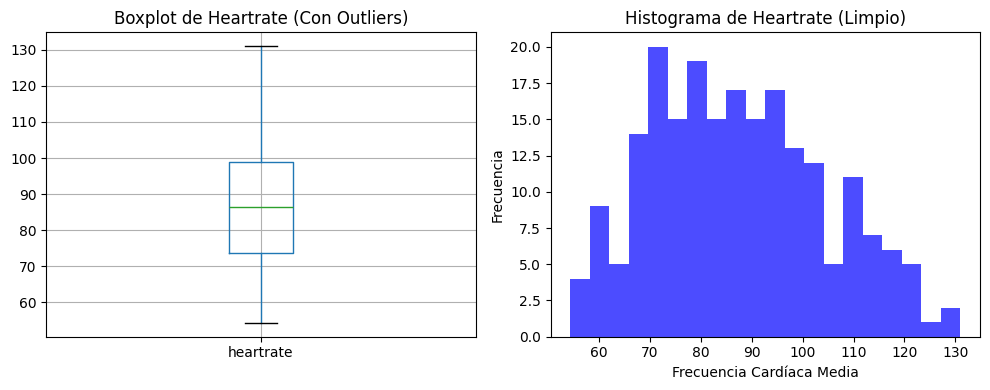

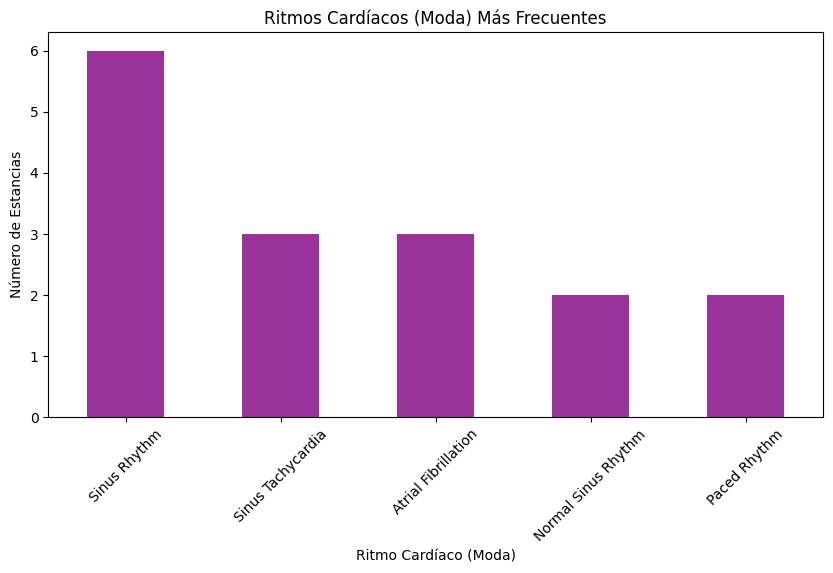

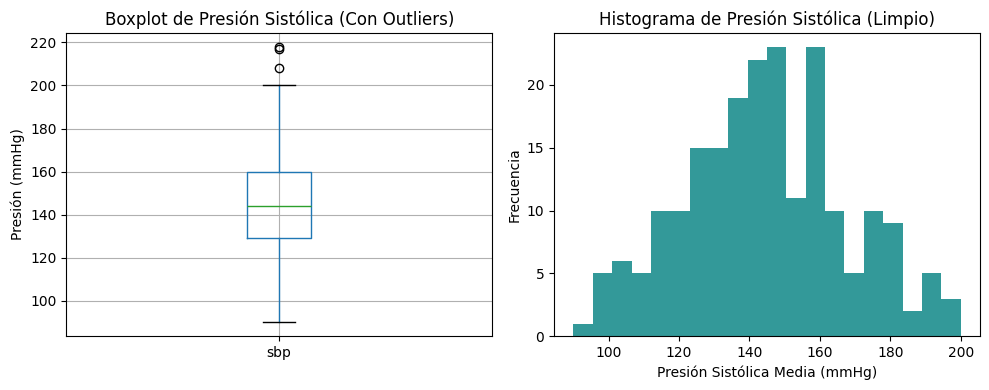

In [25]:
import matplotlib.pyplot as plt

def detect_outliers_iqr(df_in, features, k=1.5):
    out_idx = set()
    for col in features:
        Q1 = df_in[col].quantile(0.25)
        Q3 = df_in[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        ids = df_in[(df_in[col] < lower) | (df_in[col] > upper)].index
        out_idx.update(ids.tolist())
    return sorted(list(out_idx))

# -------------
# heartrate (Frecuencia Cardíaca Media)
# -------------

# Voy a analizar la columna heartrate que creamos (la media de todas las mediciones).

# --- Limpieza de Nulos ---
null_count = df_final['heartrate'].isnull().sum()
print(f"Número de nulos en 'heartrate': {null_count}")

# Para el análisis, creamos un df temporal sin esos nulos
df_analysis = df_final.dropna(subset=['heartrate'])

# --- Detección de Atípicos ---
outlier_indices = detect_outliers_iqr(df_analysis, ['heartrate'])
print(f"Número de outliers detectados en 'heartrate': {len(outlier_indices)}")

# Creamos un DataFrame LIMPIO (sin outliers) para comparar
df_clean_hr = df_analysis.drop(outlier_indices)

# -------------
# rhythm
# -------------

# --- 1. Conteo de categorías ---
# Usamos .value_counts() para contar cada ritmo único.
# Usamos dropna=False para que también cuente los 'NaN' (nulos).

print("Conteo de 'rhythm' (moda):")
print(df_final['rhythm'].value_counts(dropna=False).head(10))

# Para la visualización, es más limpio tomar los 10 ritmos más
# comunes, excluyendo los nulos (por eso no ponemos dropna=False aquí).

top_rhythms = df_final['rhythm'].value_counts().head()

# -------------
# sbp (Presión Arterial Sistólica)
# -------------

# --- 1. Limpieza de Nulos ---
null_count_sbp = df_final['sbp'].isnull().sum()
print(f"Número de nulos en 'sbp': {null_count_sbp}")

df_analysis_sbp = df_final.dropna(subset=['sbp'])

# --- 2. Detección de Atípicos ---
outlier_indices_sbp = detect_outliers_iqr(df_analysis_sbp, ['sbp'])
print(f"Número de outliers detectados en 'sbp': {len(outlier_indices_sbp)}")

# --- 3. Creación del DataFrame Limpio ---
df_clean_sbp = df_analysis_sbp.drop(outlier_indices_sbp)


# -------------
# Visualización
# -------------

# -------------
# heartrate (Frecuencia Cardíaca Media)
# -------------

# 1. Boxplot (CON outliers)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1er gráfico
df_analysis[['heartrate']].boxplot()
plt.title('Boxplot de Heartrate (Con Outliers)')

# 2. Histograma (SIN outliers)
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2º gráfico
plt.hist(df_clean_hr['heartrate'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Heartrate (Limpio)')
plt.xlabel('Frecuencia Cardíaca Media')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta los gráficos
plt.show()

# -------------
# rhythm
# -------------

plt.figure(figsize=(10, 5)) # Damos un tamaño cómodo al gráfico
top_rhythms.plot(kind='bar', color='purple', alpha=0.8)

plt.title('Ritmos Cardíacos (Moda) Más Frecuentes')
plt.ylabel('Número de Estancias')
plt.xlabel('Ritmo Cardíaco (Moda)')
plt.xticks(rotation=45) # Rotamos las etiquetas del eje X para que se lean
plt.show()

# -------------
# sbp (Presión Arterial Sistólica)
# -------------
plt.figure(figsize=(10, 4)) # Tamaño de la figura

# 1. Boxplot (CON outliers)
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1er gráfico
df_analysis_sbp[['sbp']].boxplot()
plt.title('Boxplot de Presión Sistólica (Con Outliers)')
plt.ylabel('Presión (mmHg)')

# 2. Histograma (SIN outliers)
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2º gráfico
plt.hist(df_clean_sbp['sbp'], bins=20, color='teal', alpha=0.8)
plt.title('Histograma de Presión Sistólica (Limpio)')
plt.xlabel('Presión Sistólica Media (mmHg)')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta los gráficos
plt.show()


## 4️⃣ Conversión de diagnósticos ICD a texto
Ejemplo de conversión de códigos ICD a texto usando el paquete `icd10`.

**Tu tarea:** aplicar este procedimiento a los diagnósticos de tu `df_merged`.

In [26]:
!pip install simple-icd-10


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 3.6 MB/s eta 0:00:00


In [27]:
import simple_icd_10 as icd
import matplotlib.pyplot as plt

icd.get_description("R55")

def icd_to_text(icd_string):
    # Primero nos aseguramos de que sea un string y no un 'NaN'
    if not isinstance(icd_string, str):
        return None

    # Partimos el string por la coma y el espacio
    codes = icd_string.split(', ')

    descriptions = []
    for code in codes:
        try:
            desc = icd.get_description(code)
            descriptions.append(desc)
        except:
            # Si un código no se encuentra, simplemente añadimos 'Código desconocido'
            descriptions.append(f"Código desconocido ({code})")

    # Unimos todas las descripciones con un " | "
    return ' | '.join(descriptions)


if 'all_icd_codes' in df_final.columns:
    df_final['all_icd_titles_full'] = df_final['all_icd_codes'].apply(icd_to_text)

    print(df_final[['all_icd_codes', 'all_icd_titles_full']].head())
else:
    print("Error: La columna 'all_icd_codes' no se encontró en df_final.")

                   all_icd_codes  \
0      0389, 78552, 99592, E9479   
1                            R55   
2                          H9312   
3  25000, 2761, 29410, 3310, 486   
4                          I2699   

                                 all_icd_titles_full  
0  Código desconocido (0389) | Código desconocido...  
1                               Syncope and collapse  
2                         Código desconocido (H9312)  
3  Código desconocido (25000) | Código desconocid...  
4                         Código desconocido (I2699)  


### 🧠 Ejercicio 3
Convierte los diagnósticos ICD de tu `df_merged` a texto descriptivo y analiza:
- Cuáles son los diagnósticos más frecuentes.
- Qué categorías clínicas predominan.


--- Diagnósticos Individuales Más Frecuentes ---
icd_title
HYPERTENSION NOS                                  21
Long term (current) use of insulin                19
Essential (primary) hypertension                  13
DIABETES UNCOMPL ADULT                            12
Type 2 diabetes mellitus without complications     9
Chest pain, unspecified                            8
HYPERCHOLESTEROLEMIA                               7
Acute kidney failure, unspecified                  7
CONGESTIVE HEART FAILURE, UNSPEC                   6
ALTERED MENTAL STATUS                              6
Dyspnea, unspecified                               6
Weakness                                           6
Urinary tract infection, site not specified        6
Unspecified atrial fibrillation                    6
ACUTE KIDNEY FAILURE, UNSPECIFIED                  6
Name: count, dtype: int64


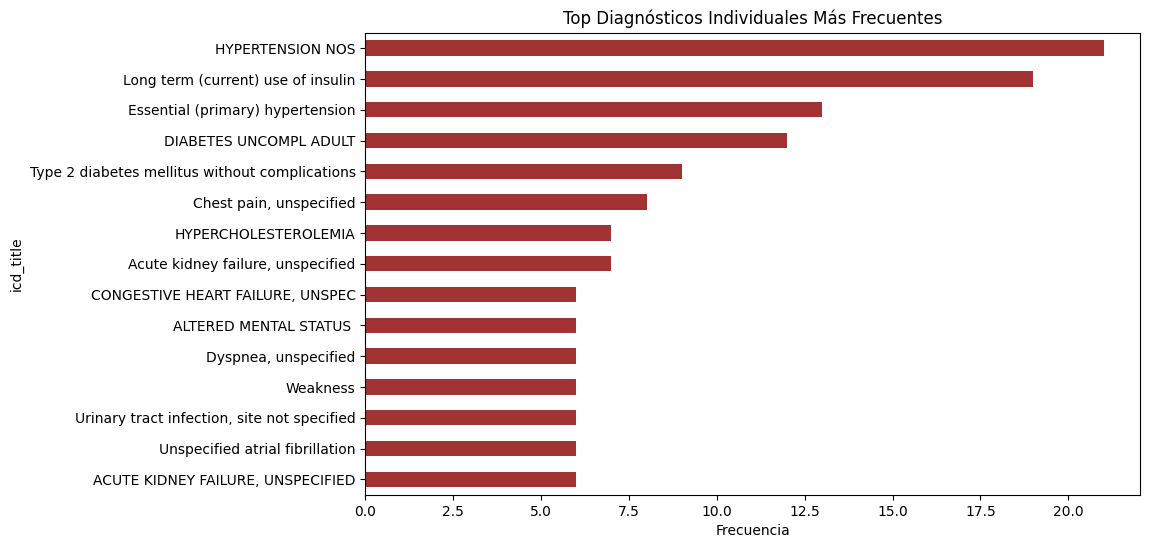

In [28]:
# Usamos LA TABLA ORIGINAL 'df_diagnosis' para esto
if 'icd_title' in df_diagnosis.columns:
    print("\n--- Diagnósticos Individuales Más Frecuentes ---")

    # Contamos los títulos de diagnóstico más comunes
    top_diagnoses = df_diagnosis['icd_title'].value_counts().head(15)

    print(top_diagnoses)

    # Visualización
    plt.figure(figsize=(10, 6))
    top_diagnoses.plot(kind='barh', color='darkred', alpha=0.8) # barh = barras horizontales
    plt.title('Top Diagnósticos Individuales Más Frecuentes')
    plt.xlabel('Frecuencia')
    plt.gca().invert_yaxis()
    plt.show()

# Clustering

Columnas seleccionadas para clustering: 28
Varianza explicada por los 2 componentes: 0.18


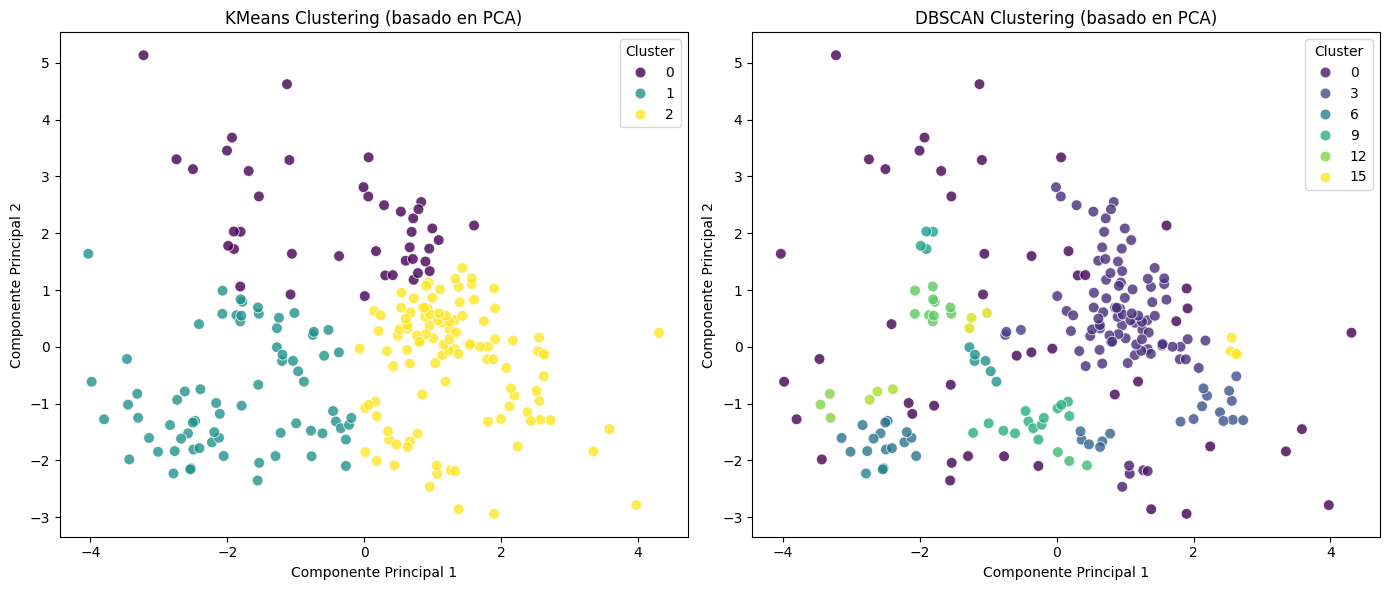

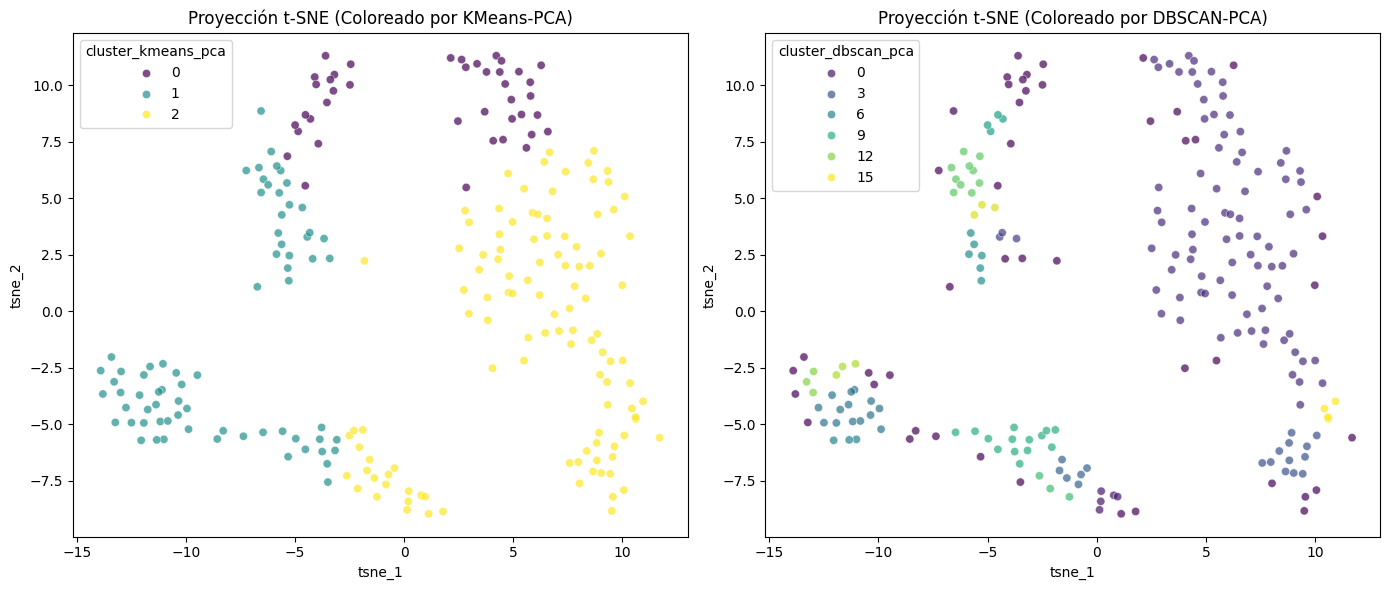

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

# ==========================================
# 1. PREPROCESAMIENTO DE DATOS
# ==========================================

# Definir columnas a excluir (IDs y textos no numéricos)
cols_to_exclude = ['stay_id', 'hadm_id', 'all_icd_codes', 'charttime', 'all_med_names', 'all_med_classes']

# Seleccionar columnas numéricas excluyendo las listas negras
numeric_cols = [col for col in df_cluster.select_dtypes(include=np.number).columns
                if col not in cols_to_exclude]

print(f"Columnas seleccionadas para clustering: {len(numeric_cols)}")

# Crear sub-dataframe y manejar valores nulos (Imputación)
merged_numeric = df_cluster[numeric_cols].copy()
imputer = SimpleImputer(strategy='mean') # Estrategia: media
merged_numeric_imputed = imputer.fit_transform(merged_numeric)

# Escalar los datos (Estandarización)
# Es crucial para PCA y Clustering que los datos tengan media 0 y varianza 1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_numeric_imputed)

# ==========================================
# 2. REDUCCIÓN DE DIMENSIONES (PCA)
# ==========================================
# Aplicamos PCA para reducir la dimensionalidad antes de clusterizar.
# Aquí reducimos a 2 componentes para facilitar la visualización y el clustering base.



pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(scaled_data)

# Guardamos los componentes en el dataframe principal para visualizarlos luego
df_cluster['pca_1'] = pca_components[:, 0]
df_cluster['pca_2'] = pca_components[:, 1]

print(f"Varianza explicada por los 2 componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

# ==========================================
# 3. GENERACIÓN DE CLUSTERS (Sobre PCA)
# ==========================================

# --- A. KMeans ---
# Aplicamos KMeans sobre los componentes del PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster_kmeans_pca'] = kmeans_pca.fit_predict(pca_components)

# --- B. DBSCAN ---
# Aplicamos DBSCAN sobre los componentes del PCA
# Nota: DBSCAN es sensible a la escala, pero como PCA viene de datos escalados, suele funcionar bien.
dbscan_pca = DBSCAN(eps=0.3, min_samples=3)
df_cluster['cluster_dbscan_pca'] = dbscan_pca.fit_predict(pca_components)

# ==========================================
# 4. VISUALIZACIÓN DE CLUSTERS (PCA)
# ==========================================

plt.figure(figsize=(14, 6))

# Gráfico 1: KMeans sobre PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_kmeans_pca',
                data=df_cluster, palette='viridis', s=60, alpha=0.8)
plt.title('KMeans Clustering (basado en PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')

# Gráfico 2: DBSCAN sobre PCA
plt.subplot(1, 2, 2)
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_dbscan_pca',
                data=df_cluster, palette='viridis', s=60, alpha=0.8)
plt.title('DBSCAN Clustering (basado en PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

# ==========================================
# 5. VISUALIZACIÓN AVANZADA (t-SNE)
# ==========================================
# t-SNE proyecta datos de alta dimensión en 2D preservando la estructura local.
# Usamos el resultado del PCA como entrada para t-SNE para mejorar la velocidad y reducir ruido.

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(pca_components)

df_cluster['tsne_1'] = tsne_result[:, 0]
df_cluster['tsne_2'] = tsne_result[:, 1]

plt.figure(figsize=(14, 6))

# Visualizamos los clusters que encontramos con KMeans pero proyectados en t-SNE
plt.subplot(1, 2, 1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster_kmeans_pca',
                data=df_cluster, palette='viridis', alpha=0.7)
plt.title('Proyección t-SNE (Coloreado por KMeans-PCA)')

# Visualizamos los clusters de DBSCAN proyectados en t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster_dbscan_pca',
                data=df_cluster, palette='viridis', alpha=0.7)
plt.title('Proyección t-SNE (Coloreado por DBSCAN-PCA)')

plt.tight_layout()
plt.show()

# Reglas de asociación

In [30]:
# subir soporte 0.6 y vamos bajandolo poquito a poco


In [ ]:

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import numpy as np

# 1. Preparar las transacciones
# Seleccionamos las columnas relevantes de df_rules para las reglas de asociación
# Excluiremos 'stay_id', 'intime', 'outtime' y otras que no son ítems

# Columnas discretizadas y de codificación binaria directa
item_cols = [
    'sexo', 'hr_binned', 'sbp_binned', 'tem_max', 'tem_min',
    'estancia_binned', 'acuity_binned', 'hipoxia', 'taquicardia'
]

# Columnas One-Hot ya creadas. Se añadirán como ítems si su valor es 1.
oh_cols = [
    col for col in df_rules.columns
    if col.startswith(('arrival_transport_', 'disposition_', 'estacion_'))
]

# Columnas con múltiples ítems (listas o strings separados por '|')
multi_item_cols = ['all_icd_titles', 'all_med_names', 'all_med_classes']

# Crear la lista de transacciones
transactions = []
for index, row in df_rules.iterrows():
    current_transaction = []

    # Añadir ítems de columnas discretizadas y binarias
    for col in item_cols:
        if pd.notna(row[col]):
            current_transaction.append(str(row[col]))

    # Añadir ítems de columnas One-Hot (si su valor es 1)
    for col in oh_cols:
        if row[col] == 1: # Si la columna one-hot es True (1)
            current_transaction.append(col) # Añadimos el nombre de la columna como ítem

  #  # Añadir ítems de columnas con múltiples ítems (ICD, medicamentos) !!!Comentado porque consume toda la RAM!!!!
  #   for col in multi_item_cols:
  #       value = row[col]

  #       # Si el valor es una lista, la procesamos
  #       if isinstance(value, list):
  #           # Limpiar elementos de la lista (eliminar NaNs y vacíos) antes de añadir
  #           cleaned_items = [str(item).strip() for item in value if pd.notna(item) and str(item).strip() != '']
  #           if cleaned_items:
  #               current_transaction.extend(cleaned_items)
  #       # Si es un string, lo procesamos (all_icd_titles es un string)
  #       elif isinstance(value, str):
  #           if value.strip() != '':
  #               items = [item.strip() for item in value.split('|') if item.strip() != '']
  #               current_transaction.extend(items)
  #       # Si es un valor escalar NaN, lo saltamos
  #       elif pd.isna(value):
  #           continue

    if current_transaction:
        transactions.append(list(set(current_transaction))) # Eliminamos duplicados dentro de la transacción

# 2. Convertir la lista de transacciones a formato One-Hot Encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# 3. Aplicar el algoritmo Apriori para encontrar ítems frecuentes
frequent_itemsets = apriori(df_transactions, min_support=0.05, use_colnames=True)

# 4. Generar reglas de asociación
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Opcional: Mostrar las reglas ordenadas por 'lift' para ver las asociaciones más interesantes
print("\n--- Reglas de Asociación (ordenadas por Lift) ---")
rules_sorted = rules.sort_values(by="lift", ascending=False)
print(rules_sorted.head(10)) # Mostrar las 10 primeras reglas por lift

print("\n--- Descripción de las métricas ---")
print("* **Support (Soporte):** Indica la frecuencia con la que aparecen los ítems en el conjunto de datos. Un soporte de 0.1 significa que el 10% de las transacciones contienen esos ítems.")
print("* **Confidence (Confianza):** Mide la fiabilidad de la regla. Una confianza de 0.8 significa que el 80% de las transacciones que contienen el antecedente también contienen el consecuente.")
print("* **Lift (Elevación):** Mide la fuerza de una regla en comparación con la aparición aleatoria. Un lift > 1 indica una asociación positiva (los ítems aparecen juntos más de lo esperado), un lift < 1 indica una asociación negativa, y un lift = 1 indica que son independientes.")
